# Introduction To Data Science - Final Project

## Group members:

| Name              | ID       |
|-------------------|----------|
| Pham Dang Son Ha |          |
| Tran Dai Nien     | 21127664 |
| Nguyen Cao Khoi   | 21127632 |
| Nguyen Phan Minh Triet  | 21126007  |

## Table of Contents

1. [Data Collection](#data-collection)

2. [Data Preprocessing and Exploration](#data-preprocessing-and-exploration)

3. [Data Modeling](#data-modeling)

4. [Reference](#references)

## Data Collection

### 1. Set-up environment

#### Import Required Libraries: Import the necessary Python libraries - requests, BeautifulSoup, pandas, and time.

In [446]:
#Necessary Packages
!pip install bs4
!pip install requests
!pip install pandas
!pip install numpy
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# modeling stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

### 2. Collect data from a website by parsing HTML

#### List of collected information

Information related to the movie, including:

- `names`: Movie titles.
- `years`: Release years of the movies.
- `genres`: Categories or genres the movies belong to.
- `lengths`: Duration or length of the movies.
- `rating_stars`: Ratings received by the movies.
- `metascores`: Metascores assigned to the movies (if available).
- `votes`: Total votes accumulated by the movies.
- `grosses`: Box office gross earnings of the movies (if available).
- `directors`: Directors of the movies.
- `stars`: Lead actors/actresses in the movies.
- `descriptions`: Synopsis or descriptions of the movies.

#### Data Collection Process:

- Identify the URL of the webpage containing the list of movies to be scraped.
- Use the requests library to send GET requests to each page of the IMDb website.
- Parse the HTML of the webpage using BeautifulSoup to extract information about the movies.
- Iterate through each movie to collect details such as title, release year, genre, rating, - Metascore, votes, earnings, director, main cast, and description.
- Store the collected information in a DataFrame using the pandas library.

In [447]:
def collect_data(base_url, num_movies, movies_per_page=100):
    # Initialize lists for storing data
    names = []
    years = []
    genres = []
    lengths = []
    rating_stars = []
    metascores = []
    votes = []
    grosses = []
    directors = []
    stars = []
    descriptions = []

    # Iterate over the specified number of pages
    for page in range(1, int(num_movies / movies_per_page) + 1):
        try:
            # Construct the URL for the current page
            url = f"{base_url}&page={page}"
            
            # Send a GET request to the URL
            response = requests.get(url)
            time.sleep(2)  # Respectful crawling by adding delay

            # Check if the response status code is 200 (OK)
            if response.status_code == 200:
                # Parse the HTML content of the page
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find all movie containers on the page
                movies = soup.find_all('div', class_='lister-item-content')

                # Process each movie
                for movie in movies:
                    # Extract movie details
                    name = movie.find('h3').find('a').text.strip()
                    year = movie.find('span', class_='lister-item-year').text.strip('()')
                    genre = movie.find('span', class_='genre').text.strip()
                    length = movie.find('span', class_='runtime').text.strip().split()[0]
                    rating = movie.find('span', class_='ipl-rating-star__rating').text.strip()

                    # Some movies might not have a metascore
                    metascore_tag = movie.find('span', class_='metascore')
                    metascore = metascore_tag.text.strip() if metascore_tag else 'N/A'

                    # Extract votes and gross, if available
                    nv_tags = movie.find_all('span', attrs={'name': 'nv'})
                    vote = nv_tags[0].text if nv_tags else 'N/A'
                    gross = nv_tags[1].text if len(nv_tags) > 1 else 'N/A'

                    # Extract director and stars
                    director, *star_list = movie.find_all('a', href=lambda href: href and 'name/nm' in href)
                    director = director.text
                    stars_str = ', '.join(star.text for star in star_list)

                    # Extract description
                    description = movie.find_all('p', class_='')[-1].text.strip()

                    # Append the extracted data to respective lists
                    names.append(name)
                    years.append(year)
                    genres.append(genre)
                    lengths.append(length)
                    rating_stars.append(rating)
                    metascores.append(metascore)
                    votes.append(vote)
                    grosses.append(gross)
                    directors.append(director)
                    stars.append(stars_str)
                    descriptions.append(description)

            else:
                print(f"Failed to process page {page}: Status code {response.status_code}")

        except requests.exceptions.RequestException as e:
            print(f"Request error on page {page}: {e}")
        except Exception as e:
            print(f"Error on page {page}: {e}")

    # Create a DataFrame with the collected data
    data = pd.DataFrame({
        'Name': names,
        'Year': years,
        'Genre': genres,
        'Length': lengths,
        'Rating': rating_stars,
        'Metascore': metascores,
        'Votes': votes,
        'Gross': grosses,
        'Director': directors,
        'Stars': stars,
        'Description': descriptions
    })

    return data

#### Collecting Movie Data from IMDb

- Identify the URL of the webpage containing the list of movies to be scraped.

- Use the collect_data function to gather information from the webpage based on the desired number of pages and movies.


In [448]:
# Specify the URL containing the list of movies
url = "https://www.imdb.com/list/ls051785783/?st_dt=&mode=detail&sort=list_order,asc"

# Scrape the data

if os.path.isfile('data_film.csv'):
  data_film = pd.read_csv('data_film.csv')
else: 
  data_film = collect_data(url, 1500, 100)

#### Data Storage

- Store the collected data in a CSV file named data_film.csv using data_film.to_csv().
- Read the data from the CSV file into a new DataFrame (data_film) using pd.read_csv().

In [449]:
#Save to csv file with name data_film.csv
# Save the DataFrame to a CSV file without including the index
data_film.to_csv("data_film.csv", index=False)

# Read the CSV file into a new DataFrame called data_film
data_film = pd.read_csv("data_film.csv")

# Display the 'data_film' DataFrame
data_film

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
0,Bố Già,1972,"Crime, Drama",175,9.2,100.0,"1,967,180",$134.97M,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","Don Vito Corleone, head of a mafia family, dec..."
1,Chuyện Tình Thế Chiến,1942,"Drama, Romance, War",102,8.5,100.0,"595,530",$1.02M,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical expatriate American cafe owner strug...
2,Sinh Viên Tốt Nghiệp,1967,"Comedy, Drama, Romance",106,8.0,83.0,"284,817",$104.95M,Mike Nichols,"Dustin Hoffman, Anne Bancroft, Katharine Ross,...",A disillusioned college graduate finds himself...
3,Công Dân Kane,1941,"Drama, Mystery",119,8.3,100.0,"458,887",$1.59M,Orson Welles,"Orson Welles, Joseph Cotten, Dorothy Comingore...",Following the death of publishing tycoon Charl...
4,12 Người Đàn Ông Giận Dữ,1957,"Crime, Drama",96,9.0,97.0,"841,356",$4.36M,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",The jury in a New York City murder trial is fr...
...,...,...,...,...,...,...,...,...,...,...,...
1495,Quái Thú Vô Hình,1987,"Action, Adventure, Horror",107,7.8,47.0,"444,578",$59.74M,John McTiernan,"Arnold Schwarzenegger, Carl Weathers, Kevin Pe...",A team of commandos on a mission in a Central ...
1496,Chuyến Du Lịch Châu Âu,2004,Comedy,92,6.6,45.0,"218,869",$17.72M,Jeff Schaffer,"Alec Berg, David Mandel, Scott Mechlowicz, Jac...","Dumped by his girlfriend, a high school grad d..."
1497,Champagne,1928,Comedy,86,5.4,NaN,"2,572",NaN,Alfred Hitchcock,"Betty Balfour, Jean Bradin, Ferdinand von Alte...",A spoiled heiress defies her father by running...
1498,Thế Giới Không Đủ,1999,"Action, Adventure, Thriller",128,6.4,57.0,"207,600",$126.94M,Michael Apted,"Pierce Brosnan, Sophie Marceau, Robert Carlyle...",James Bond uncovers a nuclear plot while prote...


## Data Exploration And Preprocessing

### 1) How many rows and columns

- There are 1500 rows and 11 columns

In [450]:
data_film.shape

(1500, 11)

### 2) What is the meaning of each row?

- Each row represents the information of a film(name, year, genres,...)

In [451]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
69,Giai Điệu Kỳ Diệu,1940,"Animation, Family, Fantasy",124,7.7,96.0,"101,940",$76.41M,Leopold Stokowski,"Walt Disney, James Algar, Samuel Armstrong, Fo...",A series of eight famous pieces of classical m...


### 3) Are there duplicated rows?

There is 0 duplicated row

In [452]:
data_film.duplicated().sum()

0

### 4) What is the meaning of each columns

- `names`: Movie titles.
- `years`: Release years of the movies.
- `genres`: Categories or genres the movies belong to.
- `lengths`: Duration or length of the movies.
- `rating_stars`: Ratings received by the movies.
- `metascores`: Metascores assigned to the movies (if available).
- `votes`: Total votes accumulated by the movies.
- `grosses`: Box office gross earnings of the movies (if available).
- `directors`: Directors of the movies.
- `stars`: Lead actors/actresses in the movies.
- `descriptions`: Synopsis or descriptions of the movies.

### 5) What is the current data type of each column? Are there any columns having inappropriate data types?

In [453]:
data_film.dtypes

Name            object
Year            object
Genre           object
Length           int64
Rating         float64
Metascore      float64
Votes           object
Gross           object
Director        object
Stars           object
Description     object
dtype: object

In [454]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
1331,Một Thời Ở Mexico,2003,"Action, Crime, Thriller",102,6.3,56.0,"167,878",$56.36M,Robert Rodriguez,"Antonio Banderas, Salma Hayek, Johnny Depp, Wi...","Hitman ""El Mariachi"" becomes involved in inter..."


- There are some columns which have inappropriate type: `Year, Votes, Gross`

- For `Year, Votes` we can simply convert them into **numeric**. But with `Gross` we need to change columns name to `Gross(M$)` to indicated that `Gross` unit is million Dollars

In [455]:
# remove ',' in Votes
data_film.Votes = data_film.Votes.str.replace(',', '')

# remove $, M in Gross and create new column `Gross(M$)`
data_film['Gross(M$)'] = data_film.Gross.str.replace('M', '').str.replace('$', '')

# drop Gross
data_film.drop(columns='Gross', inplace=True)

In [456]:
data_film.sample(1)

,Name,Year,Genre,Length,Rating,Metascore,Votes,Director,Stars,Description,Gross(M$)
298,Một Tâm Hồn Đẹp,2001,"Biography, Drama",135,8.2,72.0,969253,John Nash,"Ron Howard, Russell Crowe, Ed Harris, Jennifer...","After John Nash, a brilliant but asocial mathe...",170.74


- Convert them into **numeric**

In [457]:
to_numeric_cols = ['Year', 'Votes', 'Gross(M$)']

for col in to_numeric_cols:
  data_film[col] = pd.to_numeric(data_film[col], errors='coerce')

data_film.dtypes

Name            object
Year           float64
Genre           object
Length           int64
Rating         float64
Metascore      float64
Votes            int64
Director        object
Stars           object
Description     object
Gross(M$)      float64
dtype: object

### 6) With each numerical column, how are values distributed?

- All numerical columns:

In [458]:
numerical_cols = data_film.columns[(data_film.dtypes != 'object')]
numerical_cols

Index(['Year', 'Length', 'Rating', 'Metascore', 'Votes', 'Gross(M$)'], dtype='object')

#### 6.1) What is the percentage of missing values?

- Number of missing values of each columns

In [459]:
data_film[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1472 non-null   float64
 1   Length     1500 non-null   int64  
 2   Rating     1500 non-null   float64
 3   Metascore  1211 non-null   float64
 4   Votes      1500 non-null   int64  
 5   Gross(M$)  1121 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 70.4 KB


- The percentage of missing values for each columns

In [460]:
data_film.isnull().mean() * 100

Name            0.000000
Year            1.866667
Genre           0.000000
Length          0.000000
Rating          0.000000
Metascore      19.266667
Votes           0.000000
Director        0.000000
Stars           0.000000
Description     0.000000
Gross(M$)      25.266667
dtype: float64

> `Gross(M$)` and `Metascore` missing value's percentage are high

- The distribution of numerical attributes

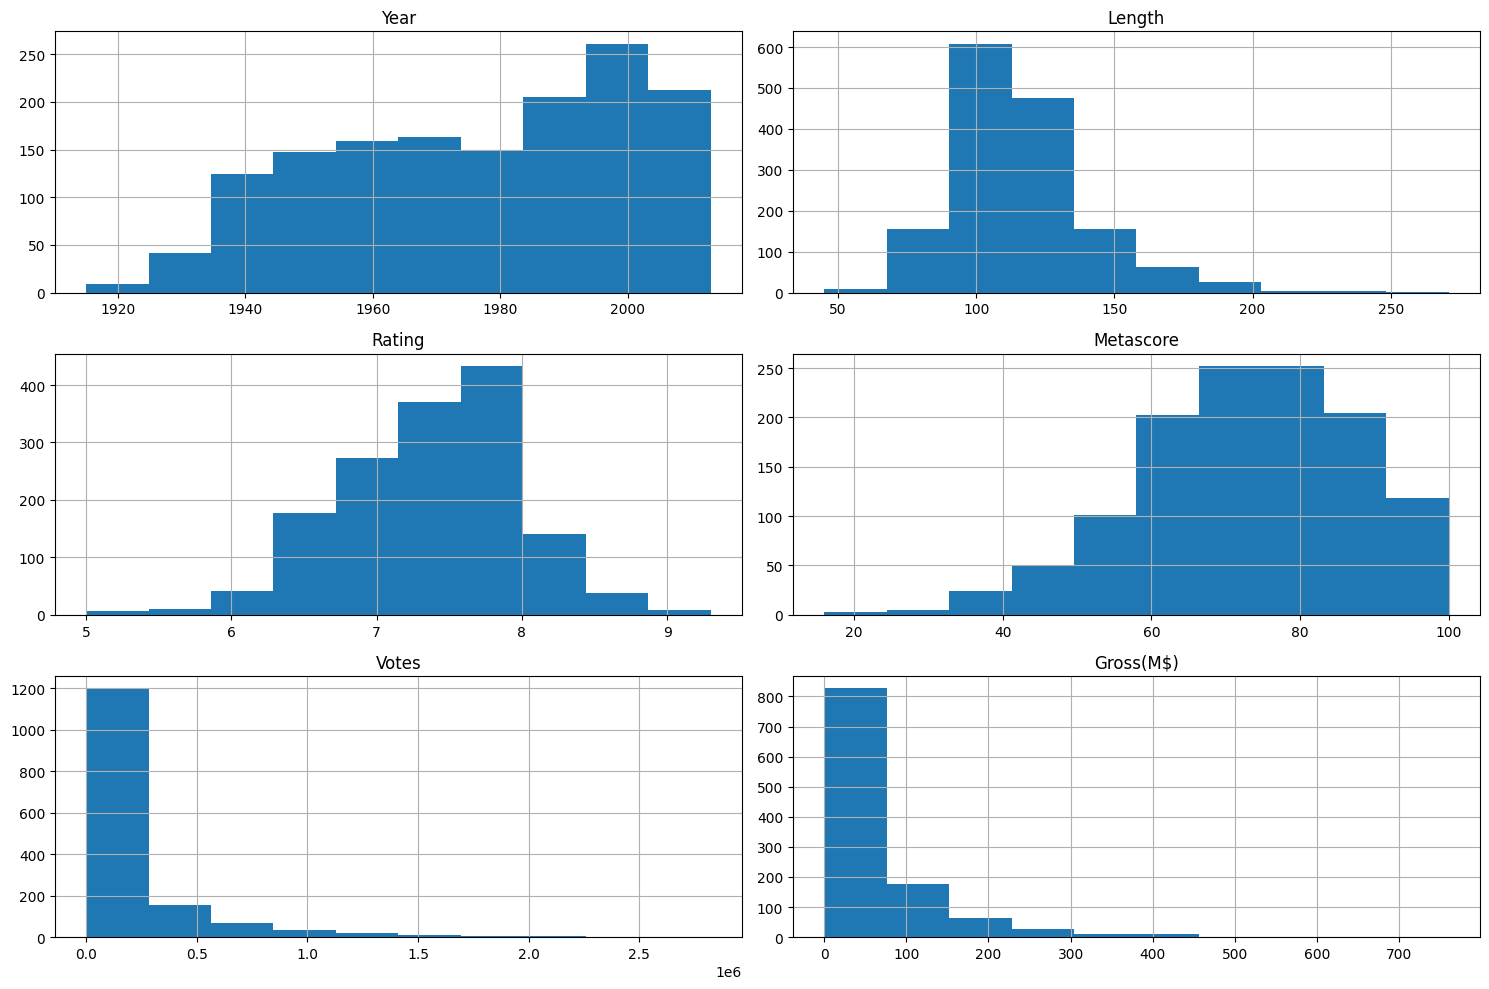

In [461]:
data_film[numerical_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show();

- General statistics of numerical attributes

In [462]:
data_film[numerical_cols].describe()

,Year,Length,Rating,Metascore,Votes,Gross(M$)
count,1472.000000,1500.000000,1500.000000,1211.000000,1.500000e+03,1121.000000
mean,1976.701087,115.578667,7.372667,72.841453,1.982493e+05,61.061802
std,23.640039,25.450913,0.613360,14.646850,3.254139e+05,80.618053
min,1915.000000,45.000000,5.000000,16.000000,4.400000e+02,0.010000
25%,1957.000000,99.000000,7.000000,63.000000,1.929475e+04,10.250000
50%,1980.000000,112.000000,7.400000,73.000000,7.339200e+04,32.870000
75%,1998.000000,127.000000,7.800000,84.000000,2.280785e+05,78.900000
max,2013.000000,271.000000,9.300000,100.000000,2.822322e+06,760.510000


### 7) With each categorical column, how are values distributed?

- Quick glance at categorical columns

In [463]:
categorical_cols = data_film.columns[data_film.dtypes == 'object']

categorical_cols

Index(['Name', 'Genre', 'Director', 'Stars', 'Description'], dtype='object')

- Missing values = 0

In [464]:
for col in categorical_cols:
  print((data_film[col] == 'nan').sum(), data_film[col].isna().sum())

0 0
0 0
0 0
0 0
0 0


- The distribution of `Name`: the counts is not significantly different so we won't plot this

In [465]:
data_film.Name.value_counts()

Name
King Kong               2
Cặp Bài Trùng           2
Kẻ Cắp Gặp Bà Già       2
Cuộc Sống Tươi Đẹp      2
Ngôi Nhà Ma             2
                       ..
Đội Nhặt Banh           1
Peter Pan               1
Cối Xay Gió Đỏ          1
Người Áp Chế            1
You Gotta Stay Happy    1
Name: count, Length: 1489, dtype: int64

- The distribution of `Genre`

In [466]:
data_film.Genre.value_counts()

Genre
Drama                        96
Comedy, Drama, Romance       73
Drama, Romance               70
Comedy                       69
Comedy, Drama                62
                             ..
Comedy, Fantasy, Musical      1
Drama, Horror, Mystery        1
Mystery, Sci-Fi, Thriller     1
Action, Crime, Romance        1
Action, Adventure, Horror     1
Name: count, Length: 235, dtype: int64

- The distribution of top 20 `Genres`

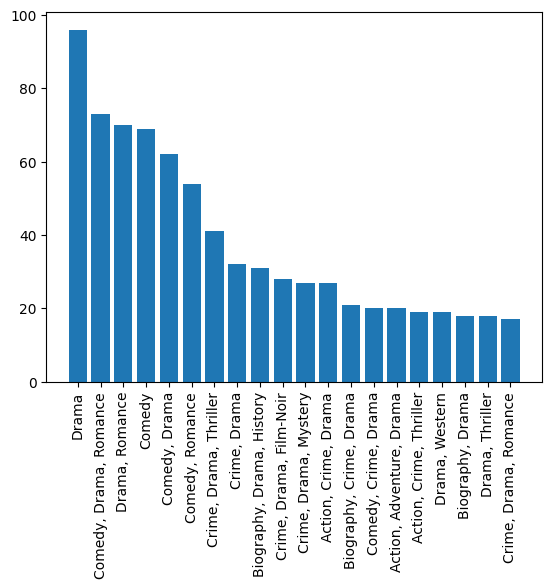

In [467]:
genre_counts = data_film.Genre.value_counts()[:20]
plt.bar(genre_counts.index, genre_counts.values);
plt.xticks(rotation=90)
plt.show();

- The distribution of `Director`

In [468]:
data_film.Director.value_counts()

Director
Alfred Hitchcock    34
Woody Allen         24
Steven Spielberg    17
Clint Eastwood      15
Martin Scorsese     14
                    ..
Henry King           1
Richard Kelly        1
Bob Rafelson         1
Mike Mills           1
Michael Apted        1
Name: count, Length: 658, dtype: int64

- The distribution of top 20 `Director`

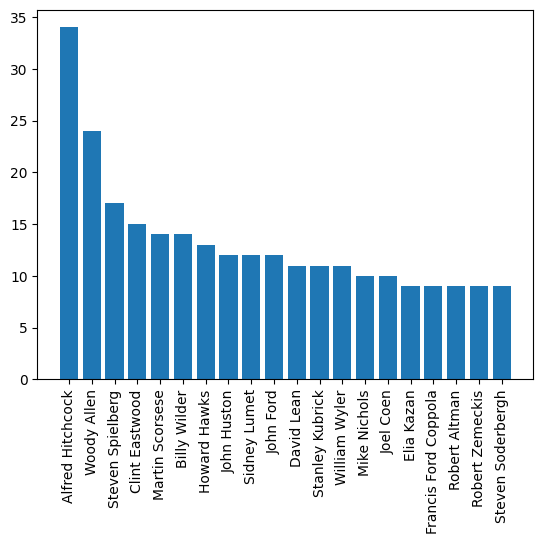

In [469]:
director_counts = data_film.Director.value_counts()[:20]
plt.bar(director_counts.index, director_counts.values);
plt.xticks(rotation=90)
plt.show()

- The distribution of `Stars`: The counts is not significantly different so we won't plot this attribute

In [470]:
data_film.Stars.value_counts()

Stars
Sylvester Stallone, Talia Shire, Burt Young, Carl Weathers                                                     4
Lewis Stone, Mickey Rooney, Cecilia Parker, Fay Holden                                                         2
Bill Murray, Dan Aykroyd, Sigourney Weaver, Harold Ramis                                                       2
Mark Hamill, Harrison Ford, Carrie Fisher, Billy Dee Williams                                                  2
Mickey Rooney, Lewis Stone, Fay Holden, Cecilia Parker                                                         2
                                                                                                              ..
Wilfred Jackson, Hamilton Luske, Jack Kinney, Bobby Driscoll, Kathryn Beaumont, Hans Conried, Bill Thompson    1
Nicole Kidman, Ewan McGregor, John Leguizamo, Jim Broadbent                                                    1
Joaquin Phoenix, Philip Seymour Hoffman, Amy Adams, Jesse Plemons                         

- The distribution of `Description`: each description is different so we won't plot this

In [471]:
data_film.Description.value_counts()

Description
Don Vito Corleone, head of a mafia family, decides to hand over his empire to his youngest son Michael. However, his decision unintentionally puts the lives of his loved ones in grave danger.                   1
One year after Kevin McCallister was left home alone and had to defeat a pair of bumbling burglars, he accidentally finds himself stranded in New York City - and the same criminals are not far behind.          1
A husband-and-wife team play detective, but not in the traditional sense. Instead, the happy duo helps others solve their existential issues, the kind that keep you up at night, wondering what it all means.    1
After his auto-parts tycoon father dies, the overweight, underachieving son teams up with a snide accountant to try and save the family business.                                                                 1
A boy and a girl from different backgrounds fall in love regardless of their upbringing - and then tragedy strikes.                         

#### 7.1) What is the percentage of missing values?

- As we can see all the categorical columns has 0 missing value so the perccentage will be: 0%

### 8) Are they abnormal?

- After considering the distribution of each attributes, we can conclude that the values are good enough for us to use for model training and get insights from them. But first, we need to preprocessing the data.

## Data modeling

- Import library for moduling

In [472]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Problem Statement

- The question that our team want to give an answer to is:  How much grosses can this new film can possibly get?
- When we want to make a film, we sure want to know how much money the film could make for us. The success or failure of a movie depends on many factor: the release date, budget, star-power, marketing,...  But with the data that our team has collected, we will answer the question above by predicting the gross with values of: Ratings, Metascore, Directors, Stars, Genres. 
- By predicting the gross, the film maker can know wheter it is possible to make the film and the prediction will help them to have a clearer vision on the plan in the production and distribution stage.


### Data preparation

In [473]:
filmdata_df = pd.read_csv("./data_film.csv")
filmdata_df.head()

,Name,Year,Genre,Length,Rating,Metascore,Votes,Gross,Director,Stars,Description
0,Bố Già,1972,"Crime, Drama",175,9.2,100.0,"1,967,180",$134.97M,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...","Don Vito Corleone, head of a mafia family, dec..."
1,Chuyện Tình Thế Chiến,1942,"Drama, Romance, War",102,8.5,100.0,"595,530",$1.02M,Michael Curtiz,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical expatriate American cafe owner strug...
2,Sinh Viên Tốt Nghiệp,1967,"Comedy, Drama, Romance",106,8.0,83.0,"284,817",$104.95M,Mike Nichols,"Dustin Hoffman, Anne Bancroft, Katharine Ross,...",A disillusioned college graduate finds himself...
3,Công Dân Kane,1941,"Drama, Mystery",119,8.3,100.0,"458,887",$1.59M,Orson Welles,"Orson Welles, Joseph Cotten, Dorothy Comingore...",Following the death of publishing tycoon Charl...
4,12 Người Đàn Ông Giận Dữ,1957,"Crime, Drama",96,9.0,97.0,"841,356",$4.36M,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",The jury in a New York City murder trial is fr...


### Data Preprocessing

In [474]:
def convertDolla2Int(series):
    value = [float(x[1:-1])  * 1000000000 for x in series ]
    return value

feature_cols = ['Rating', 'Metascore', 'Director', 'Stars', 'Genre', 'Gross']

modeling_data = filmdata_df[feature_cols].copy()
modeling_data.Gross = modeling_data.Gross.fillna('$0M')
modeling_data.Metascore = modeling_data.Metascore.fillna(0.0)
modeling_data.Rating = modeling_data.Rating.fillna(0.0)
modeling_data.Gross = convertDolla2Int(modeling_data.Gross)
modeling_data = modeling_data.join(pd.get_dummies(modeling_data[['Director', 'Stars', 'Genre']], dtype= int)).drop(['Director', 'Stars', 'Genre'], axis= 1)
modeling_data

,Rating,Metascore,Gross,Director_Adam McKay,Director_Adrian Cronauer,Director_Adrian Lyne,Director_Aileen Wuornos,Director_Akira Kurosawa,Director_Alan J. Pakula,Director_Alan Parker,...,"Genre_Musical, Romance","Genre_Musical, Romance, Western","Genre_Mystery, Romance, Thriller","Genre_Mystery, Sci-Fi, Thriller","Genre_Mystery, Thriller","Genre_Romance, Western",Genre_Thriller,"Genre_Thriller, War","Genre_Thriller, Western",Genre_Western
0,9.2,100.0,1.349700e+11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8.5,100.0,1.020000e+09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,83.0,1.049500e+11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.3,100.0,1.590000e+09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.0,97.0,4.360000e+09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,7.8,47.0,5.974000e+10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,6.6,45.0,1.772000e+10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,5.4,0.0,0.000000e+00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,6.4,57.0,1.269400e+11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [475]:
X, y = modeling_data.drop(['Gross'], axis= 1), modeling_data.Gross
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [476]:
train_data = X_train.join(y_train)
train_data

,Rating,Metascore,Director_Adam McKay,Director_Adrian Cronauer,Director_Adrian Lyne,Director_Aileen Wuornos,Director_Akira Kurosawa,Director_Alan J. Pakula,Director_Alan Parker,Director_Alejandro G. Iñárritu,...,"Genre_Musical, Romance, Western","Genre_Mystery, Romance, Thriller","Genre_Mystery, Sci-Fi, Thriller","Genre_Mystery, Thriller","Genre_Romance, Western",Genre_Thriller,"Genre_Thriller, War","Genre_Thriller, Western",Genre_Western,Gross
498,7.2,84.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.125000e+10
479,7.8,74.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
787,7.8,86.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.295000e+10
1473,7.1,46.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.812000e+10
846,7.5,74.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9.219000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,7.6,94.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.200000e+08
670,8.0,74.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.410000e+10
1262,7.1,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.301000e+10
73,7.9,69.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.117200e+11


In [477]:
test_data = X_test.join(y_test)
test_data

,Rating,Metascore,Director_Adam McKay,Director_Adrian Cronauer,Director_Adrian Lyne,Director_Aileen Wuornos,Director_Akira Kurosawa,Director_Alan J. Pakula,Director_Alan Parker,Director_Alejandro G. Iñárritu,...,"Genre_Musical, Romance, Western","Genre_Mystery, Romance, Thriller","Genre_Mystery, Sci-Fi, Thriller","Genre_Mystery, Thriller","Genre_Romance, Western",Genre_Thriller,"Genre_Thriller, War","Genre_Thriller, Western",Genre_Western,Gross
1154,6.5,59.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.826200e+11
391,7.4,70.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.237000e+10
488,7.2,63.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
136,7.6,90.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.320900e+11
1018,6.7,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,6.6,42.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.382000e+10
1491,7.1,78.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.200000e+08
577,7.6,88.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.115400e+11
207,7.7,95.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.200000e+10


### Create Model

### Trainning Model

In [478]:
X_train, y_train = train_data.drop(['Gross'], axis= 1), train_data.Gross
X_test, y_test = test_data.drop(['Gross'], axis= 1), test_data.Gross

X_train_s = StandardScaler().fit_transform(X_train)
X_test_s = StandardScaler().fit_transform(X_test)

reg = LinearRegression()
reg.fit(X_train_s, y_train)

LinearRegression()

In [479]:
reg.score(X_test_s, y_test)

-8.625546928277572e+25

In [480]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train, y_train)

RandomForestRegressor()

In [481]:
forest.score(X_test, y_test)

0.30430080929012115

### Evaluation

### Prediction

### Result Analyst

### Conclusion

## References